In [95]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.signal import square
from scipy.integrate import quad
from numpy import sqrt, exp, pi, cos, sin, log
from scipy.stats import norm, expon, lognorm
import pandas as pd
from time import perf_counter
from tqdm  import tqdm
import polars as pl
from datetime import datetime

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')
np.seterr(all = 'ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [3]:
# Global color shades
blue_shades     = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']
green_shades    = ['#005500', '#009900', '#00CC00', '#66FF66', '#99FF99']

Todo:
1. Solve problem with small T
2. more range of values for error analysis for T
3. Heston model mathematics
4. black-scholes inverse for calculating IV
5. Average IV over Calls and puts
6. plot IV
7. research minimize from scipy 
8. Tune over all data
9. Make nice plots

# Part 3

## Heston Model Mathematics

In [ ]:
S0 = 100. # initial asset price
K = 100. # strike
v0 = 0.1 # initial variance
r = 0.03 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
lambd = 0.575 # risk premium of variance
rho = -0.5711 # correlation between variance and stock process
tau = 1. # time to maturity

In [129]:
def Fourier_Heston_Put(S0, K, T, r, 
                    # Heston Model Paramters
                    kappa, # Speed of the mean reversion 
                    theta, # Long term mean
                    rho,   # correlation between 2 random variables
                    zeta,  # Volatility of volatility
                    v0,    # Initial volatility 
                    N):
    if T < .5 or v0 > .2 : N = 256

    _sigma, _T = max(.1, sqrt(v0)), max(1, T)
    a = log(S0) + r * _T - 12 * _sigma * np.sqrt(_T) # Upper limit -12 std from the expected value
    b = log(S0) + r * _T + 12 * _sigma * np.sqrt(_T) # Lower limit -12 std from the expected value

    h       = lambda n : (n*pi) / (b-a) 
    g       = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
    g0      = K*(log(K) - a - 1) + exp(a)
    
    def heston_char(u, kappa, theta, rho, zeta, v0): 
        div = 0
        d = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
        c = (kappa - rho*zeta*1j*u - d)/(kappa - rho*zeta*1j*u + d)
        beta = ( (kappa - rho*zeta*1j*u -d)*(1 - exp(-d*T)) )/(zeta**2*(1-c*exp(-d*T)))
        alpha = (kappa*theta)/zeta**2 *((kappa - rho*zeta*1j - div)*T - 2*log((1-c*exp(-div*T))/(1-c)))
        m  = log(S0) + (r-div)*T
        return exp(1j*u*m + alpha * beta*v0)

    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*heston_char(h_n, kappa, theta, rho, zeta, v0) * exp(-1j*a*h_n) * g(n)

    F = exp((-r*T))/(b-a) * np.real(F)
    return F if F > 0 else 0

## US Tresury Rates
Site: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202306

### Nelson Siegel Svensson - Python Package
Site: https://nelson-siegel-svensson.readthedocs.io/en/latest/usage.html


NelsonSiegelSvenssonCurve(beta0=1.2595121714700128, beta1=4.367186541206554, beta2=-1457.4165045532893, beta3=1458.9304400823748, tau1=6.83997027106895, tau2=6.877834685907713)

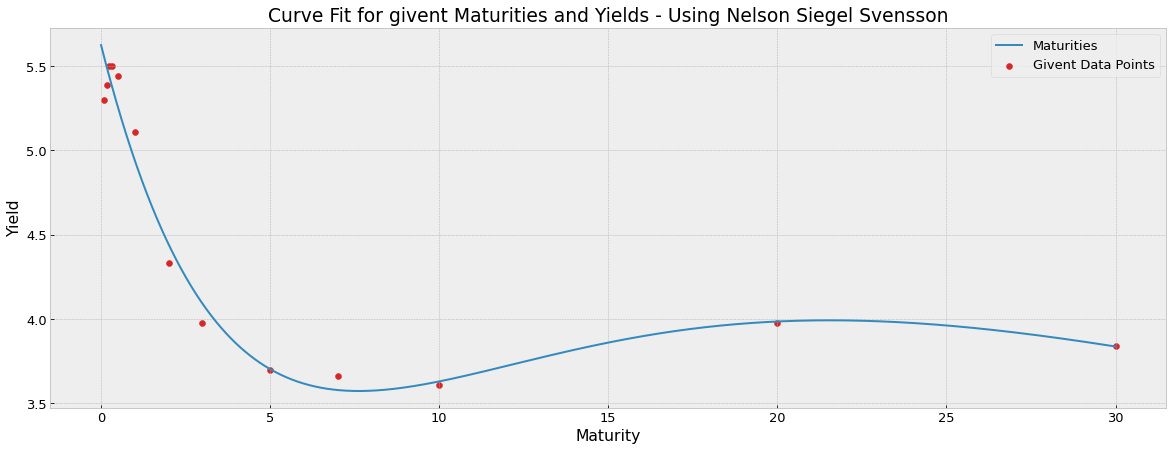

In [4]:
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

# Collected at : 06/01/2023
yield_maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yields           = np.array([5.30,5.39,5.50,5.50,5.44,5.11,4.33,3.98,3.70,3.66,3.61,3.98,3.84])

#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yields) 
ax = pd.DataFrame(np.arange(1, 30*365)/365, columns=['Maturities'], index=np.arange(1, 30*365)/365,).apply(curve_fit).plot(
    title='Curve Fit for givent Maturities and Yields - Using Nelson Siegel Svensson', xlabel='Maturity', ylabel='Yield')
ax.scatter(yield_maturities, yields, label='Givent Data Points', color='tab:red')
ax.legend()
curve_fit

In [127]:
import yfinance as yf
SPX = yf.Ticker("^SPX")

expiration_dates = SPX.options
df = []
for expiration_date in tqdm(expiration_dates):
    _df = SPX.option_chain(expiration_date).puts
    _df = _df[['strike', 'lastPrice']]
    _df = _df.rename(columns={'lastPrice': 'price'})
    _df['maturity'] = (pd.to_datetime(expiration_date) - pd.to_datetime(datetime.now())).days / 365

    df.append(_df)

df = pd.concat(df)
df = df[df['maturity'] > 0]

# Limit the space to calibrate the model according to requirements
volSurfaceLong = (
    df
    [(df['strike'] > 3000) & (df['strike'] < 4800) &  df['maturity'] > 0] # & (df['maturity'] < 1)
)
# volSurfaceLong.pivot(index='Maturity', columns='strike', values='lastPrice')
volSurfaceLong['rate'] = volSurfaceLong['maturity'].apply(curve_fit)
volSurfaceLong
# df2.dropna(axis=1)


100%|██████████| 53/53 [00:07<00:00,  6.69it/s]
/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_47957/286642856.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,strike,price,maturity,rate
6,3200.0,0.05,0.002740,5.624520
7,3300.0,0.10,0.002740,5.624520
8,3350.0,0.30,0.002740,5.624520
9,3400.0,0.05,0.002740,5.624520
10,3450.0,0.05,0.002740,5.624520
...,...,...,...,...
31,4600.0,523.24,4.476712,3.773483
6,3100.0,198.30,5.473973,3.656085
7,3200.0,216.21,5.473973,3.656085
8,3400.0,248.00,5.473973,3.656085


In [135]:
print(expiration_date)
SPX.option_chain(expiration_date).puts

2028-12-15


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPX281215P00400000,2023-06-26 14:18:36+00:00,400.0,3.30,0.0,9.1,0.0,0.0,1.0,0,0.489858,False,REGULAR,USD
1,SPX281215P00800000,2023-06-23 14:06:45+00:00,800.0,9.00,0.0,17.1,0.0,0.0,1.0,0,0.380484,False,REGULAR,USD
2,SPX281215P01600000,2023-06-26 17:13:07+00:00,1600.0,42.00,31.1,43.2,0.0,0.0,4.0,0,0.275488,False,REGULAR,USD
3,SPX281215P01800000,2023-06-20 15:11:22+00:00,1800.0,66.00,44.4,64.5,0.0,0.0,NaN,0,0.270675,False,REGULAR,USD
4,SPX281215P02000000,2023-06-20 14:53:05+00:00,2000.0,84.00,70.1,90.1,0.0,0.0,NaN,0,0.265026,False,REGULAR,USD
5,SPX281215P02800000,2023-06-22 13:30:03+00:00,2800.0,153.20,151.0,171.0,0.0,0.0,NaN,0,0.209287,False,REGULAR,USD
6,SPX281215P03100000,2023-06-22 13:30:03+00:00,3100.0,198.30,198.6,218.5,0.0,0.0,NaN,0,0.193451,False,REGULAR,USD
7,SPX281215P03200000,2023-06-22 18:41:17+00:00,3200.0,216.21,216.3,236.2,0.0,0.0,NaN,0,0.188272,False,REGULAR,USD
8,SPX281215P03400000,2023-06-22 18:41:17+00:00,3400.0,248.00,235.4,289.3,0.0,0.0,NaN,0,0.182925,False,REGULAR,USD
9,SPX281215P04000000,2023-06-26 18:40:05+00:00,4000.0,401.91,373.0,426.7,0.0,0.0,3.0,0,0.149322,False,REGULAR,USD


In [99]:
fig = px.scatter_3d(volSurfaceLong, x='maturity', y='strike', z='price', width=800, height=800)
fig.show()


In [86]:
volSurfaceLong.pivot(index='maturity', columns='strike', values='price')
volSurfaceLong_small = volSurfaceLong.sample(frac=.2)

In [101]:
def get_error_Heston(volSurfaceLong, v0, kappa, theta, zeta, rho):
    error = 0
    for _, row in volSurfaceLong.iterrows():
        P = row['price']
        HP = Fourier_Heston_Put(S0=S0, K=row['strike'], v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=row['maturity'], r=row['rate']/100, N=96)
        error += (P - HP)**2
        # print(f"""
        # K = {row.strike}
        # T = {row.maturity}
        # r = {row['rate']/100}
        # P = {P} - {HP}
        # """)
    return error / volSurfaceLong.shape[0]

def get_resutls_Heston(volSurfaceLong, v0, kappa, theta, zeta, rho):
    df = volSurfaceLong.copy(deep=True)
    df2 = volSurfaceLong.copy(deep=True)
    df['source'] = 'Observed'
    df2['source'] = 'Heston Model'
    HP = []
    for _, row in volSurfaceLong.iterrows():
        HP.append(
             Fourier_Heston_Put(S0=S0, K=row['strike'], v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho, T=row['maturity'], r=row['rate']/100, N=96)
        )
    df2['price'] = HP
    return pd.concat([df, df2])

v0= 0.1
kappa= 3
theta=0.05
zeta = 0.3
rho= -0.8

# Define variables to be used in optimization
S0 = SPX.history(end='now')['Close'][-1] ; print(f'Last Close: {S0:.2f} USD')
# get_error_Heston(volSurfaceLong_small, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho)
df
get_resutls_Heston(volSurfaceLong_small, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho)

Last Close: 4350.27 USD


,strike,price,maturity,rate,source
86,4175.0,80.580000,0.427397,5.307627,Observed
42,3880.0,1.350000,0.046575,5.589896,Observed
13,3700.0,0.850000,0.054795,5.583454,Observed
82,4140.0,78.120000,0.427397,5.307627,Observed
50,3400.0,40.400000,0.717808,5.113478,Observed
...,...,...,...,...,...
183,3905.0,4.379987,0.008219,5.620167,Heston Model
226,4355.0,97.625709,0.093151,5.553603,Heston Model
12,3600.0,-3.153121,0.005479,5.622342,Heston Model
41,3800.0,138.507526,0.427397,5.307627,Heston Model


In [133]:
from scipy.optimize import minimize

# Define variables to be used in optimization
S0 = SPX.history(end='now')['Close'][-1] ; print(f'Last Close: {S0:.2f} USD')

params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.6]}, 
          "kappa": {"x0": 3, "lbub": [1e-3,10]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.6]},
          "zeta": {"x0": 0.3, "lbub": [1e-2,4]},
          "rho": {"x0": 0.0, "lbub": [-1,0]},
          }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]
def SqErr(x):
    v0, kappa, theta, zeta, rho = [param for param in x]
    #volSurfaceLong_small   |   volSurfaceLong
    mse = get_error_Heston(volSurfaceLong_small, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho)
    print(f">>v0={v0:.4}, kappa={kappa:.4f}, theta={theta:.4f}, zeta={zeta:.4f}, rho={rho:.4f} | MSE: {mse:.4f}")
    return mse

result = minimize(SqErr, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)
# result = minimize(SqErr, x0, tol = 1e-4, method='L-BFGS-B', options={'maxiter': 1e4 }, bounds=bnds)
v0, kappa, theta, zeta, rho = [param for param in result.x]
print(f"Result \n >>v0={v0:.4}, kappa={kappa:.4f}, theta={theta:.4f}, zeta={zeta:.4f}, rho={rho:.4f}")

Last Close: 4338.09 USD
>>v0=0.1, kappa=3.0000, theta=0.0500, zeta=0.3000, rho=-0.8000 | MSE: 10883.6182
>>v0=0.1, kappa=3.0000, theta=0.0500, zeta=0.3000, rho=-0.8000 | MSE: 10883.6213
>>v0=0.1, kappa=3.0000, theta=0.0500, zeta=0.3000, rho=-0.8000 | MSE: 10883.6183
>>v0=0.1, kappa=3.0000, theta=0.0500, zeta=0.3000, rho=-0.8000 | MSE: 10883.6243
>>v0=0.1, kappa=3.0000, theta=0.0500, zeta=0.3000, rho=-0.8000 | MSE: 10883.6161
>>v0=0.1, kappa=3.0000, theta=0.0500, zeta=0.3000, rho=-0.8000 | MSE: 10883.6182
>>v0=0.6, kappa=0.0712, theta=0.6000, zeta=2.9887, rho=-0.0012 | MSE: 2715.7737
>>v0=0.6, kappa=0.0712, theta=0.6000, zeta=2.9887, rho=-0.0012 | MSE: 2715.7737
>>v0=0.6, kappa=0.0712, theta=0.6000, zeta=2.9887, rho=-0.0012 | MSE: 2715.7737
>>v0=0.6, kappa=0.0712, theta=0.6000, zeta=2.9887, rho=-0.0012 | MSE: 2715.7737
>>v0=0.6, kappa=0.0712, theta=0.6000, zeta=2.9887, rho=-0.0012 | MSE: 2715.7737
>>v0=0.6, kappa=0.0712, theta=0.6000, zeta=2.9887, rho=-0.0012 | MSE: 2715.7737
>>v0=0.6, 

/Users/alexanderithakis/miniforge3/envs/QF/lib/python3.10/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



>>v0=0.5999, kappa=0.0010, theta=0.0368, zeta=1.3203, rho=-1.0000 | MSE: 2720.2708
>>v0=0.5999, kappa=7.3341, theta=0.0389, zeta=1.8355, rho=-1.0000 | MSE: 422.3357
>>v0=0.5999, kappa=7.3341, theta=0.0389, zeta=1.8355, rho=-1.0000 | MSE: 422.3357
>>v0=0.5999, kappa=7.3341, theta=0.0389, zeta=1.8355, rho=-1.0000 | MSE: 422.3357
>>v0=0.5999, kappa=7.3341, theta=0.0389, zeta=1.8355, rho=-1.0000 | MSE: 422.3363
>>v0=0.5999, kappa=7.3341, theta=0.0389, zeta=1.8355, rho=-1.0000 | MSE: 422.3357
>>v0=0.5999, kappa=7.3341, theta=0.0389, zeta=1.8355, rho=-1.0000 | MSE: 422.3357
>>v0=0.5998, kappa=0.0010, theta=0.0422, zeta=1.3314, rho=-0.9999 | MSE: 2720.2479
>>v0=0.5999, kappa=6.2265, theta=0.0394, zeta=1.7593, rho=-0.9999 | MSE: 291.5247
>>v0=0.5999, kappa=6.2265, theta=0.0394, zeta=1.7593, rho=-0.9999 | MSE: 291.5247
>>v0=0.5999, kappa=6.2265, theta=0.0394, zeta=1.7593, rho=-0.9999 | MSE: 291.5247
>>v0=0.5999, kappa=6.2265, theta=0.0394, zeta=1.7593, rho=-0.9999 | MSE: 291.5249
>>v0=0.5999, k

In [122]:
resulds_df = get_resutls_Heston(volSurfaceLong_small, v0=v0, kappa=kappa, theta=theta, zeta=zeta, rho=rho)
fig = px.scatter_3d(resulds_df, x='maturity', y='strike', z='price', color='source', width=1200, height=800, title='Goodness of fit for the Heston model vs the Observed values')
fig.show()

In [126]:
np.abs(resulds_df[resulds_df['source']=='Heston Model']['price'] - resulds_df[resulds_df['source']=='Observed']['price']).mean()

6.23942129309248